In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# === Set up paths ===
base_path = './Symbols'
images_path = os.path.join(base_path, 'images')
folds_path = os.path.join(base_path, 'classification-task')

# === Load image function ===
def load_image(path, size=(32, 32)):
    img = Image.open(path).convert('L').resize(size)
    return np.array(img).flatten() / 255.0

# === One-hot encoding ===
def one_hot(y, num_classes):
    out = np.zeros((len(y), num_classes))
    out[np.arange(len(y)), y] = 1
    return out

# === Activation functions ===
def sigmoid(x): return 1 / (1 + np.exp(-x))
def sigmoid_deriv(x): s = sigmoid(x); return s * (1 - s)
def tanh(x): return np.tanh(x)
def tanh_deriv(x): return 1 - np.tanh(x)**2
def relu(x): return np.maximum(0, x)
def relu_deriv(x): return (x > 0).astype(float)

# === MLP ===
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', lr=0.01):
        self.lr = lr
        acts = {
            'sigmoid': (sigmoid, sigmoid_deriv),
            'tanh': (tanh, tanh_deriv),
            'relu': (relu, relu_deriv)
        }
        self.act, self.act_deriv = acts[activation]
        sizes = [input_size] + hidden_sizes + [output_size]
        self.weights = [np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i]) for i in range(len(sizes)-1)]
        self.biases = [np.zeros((1, sizes[i+1])) for i in range(len(sizes)-1)]

    def softmax(self, z):
        e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return e_z / np.sum(e_z, axis=1, keepdims=True)

    def forward(self, x):
        self.zs, self.activations = [], [x]
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            z = self.activations[-1] @ w + b
            self.zs.append(z)
            self.activations.append(self.act(z))
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        self.zs.append(z)
        self.activations.append(self.softmax(z))
        return self.activations[-1]

    def backward(self, y_true):
        grads_w, grads_b = [0]*len(self.weights), [0]*len(self.biases)
        m = y_true.shape[0]
        y_pred = self.activations[-1]
        delta = (y_pred - y_true) / m
        for i in reversed(range(len(self.weights))):
            grads_w[i] = self.activations[i].T @ delta
            grads_b[i] = np.sum(delta, axis=0, keepdims=True)
            if i != 0:
                delta = (delta @ self.weights[i].T) * self.act_deriv(self.zs[i-1])
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * grads_w[i]
            self.biases[i] -= self.lr * grads_b[i]

    def train_step(self, x, y_true):
        y_pred = self.forward(x)
        self.backward(y_true)
        return y_pred

# === Training ===
def train(model, X, y, epochs=10, batch_size=64):
    y_encoded = one_hot(y, num_classes=np.max(y)+1)
    loss_list = []
    for epoch in range(epochs):
        indices = np.random.permutation(len(X))
        X_shuffled, y_shuffled = X[indices], y_encoded[indices]
        total_loss = 0
        for i in range(0, len(X), batch_size):
            xb = X_shuffled[i:i+batch_size]
            yb = y_shuffled[i:i+batch_size]
            y_pred = model.train_step(xb, yb)
            loss = -np.mean(np.sum(yb * np.log(y_pred + 1e-8), axis=1))  # Cross-entropy
            total_loss += loss
        loss_list.append(total_loss)
    return loss_list

# === Evaluation ===
def evaluate(model, X, y):
    y_pred = model.forward(X)
    preds = np.argmax(y_pred, axis=1)
    acc = np.mean(preds == y)
    return acc

# === Cross-Validation ===
def run_cross_validation(activation='relu', hidden_sizes=[128], lr=0.01, epochs=10):
    fold_accuracies = []
    loss_per_fold = []

    for fold in range(1, 11):
        fold_path = os.path.join(folds_path, f'fold-{fold}')
        train_df = pd.read_csv(os.path.join(fold_path, 'train.csv'))
        test_df = pd.read_csv(os.path.join(fold_path, 'test.csv'))

        symbol_ids = sorted(train_df['symbol_id'].unique())
        id_to_idx = {sid: i for i, sid in enumerate(symbol_ids)}
        train_df['label'] = train_df['symbol_id'].map(id_to_idx)
        test_df['label'] = test_df['symbol_id'].map(id_to_idx)

        X_train = np.array([load_image(os.path.join(images_path,'Symbols' ,p)) for p in train_df['path']])
        y_train = np.array(train_df['label'])
        X_test = np.array([load_image(os.path.join(images_path,'Symbols', p)) for p in test_df['path']])
        y_test = np.array(test_df['label'])

        model = MLP(input_size=X_train.shape[1],
                    hidden_sizes=hidden_sizes,
                    output_size=len(symbol_ids),
                    activation=activation,
                    lr=lr)

        loss_history = train(model, X_train, y_train, epochs=epochs, batch_size=64)
        acc = evaluate(model, X_test, y_test)

        fold_accuracies.append(acc)
        loss_per_fold.append(loss_history)

        print(f"Fold {fold}: Accuracy = {acc*100:.2f}%")

    return fold_accuracies, loss_per_fold

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch  # Add PyTorch import

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === Set up paths ===
base_path = './Symbols'
images_path = os.path.join(base_path, 'images')
folds_path = os.path.join(base_path, 'classification-task')

# === Load image function ===
def load_image(path, size=(32, 32)):
    img = Image.open(path).convert('L').resize(size)
    return np.array(img).flatten() / 255.0

# === One-hot encoding ===
def one_hot(y, num_classes):
    # Using PyTorch's one_hot
    y_tensor = torch.tensor(y, device=device)
    return torch.nn.functional.one_hot(y_tensor, num_classes).float()

# === Activation functions with PyTorch ===
def sigmoid(x): return 1 / (1 + torch.exp(-x))
def sigmoid_deriv(x): s = sigmoid(x); return s * (1 - s)
def tanh(x): return torch.tanh(x)
def tanh_deriv(x): return 1 - torch.tanh(x)**2
def relu(x): return torch.maximum(torch.zeros_like(x), x)
def relu_deriv(x): return (x > 0).float()

# === MLP ===
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', optimizer='sgd', lr=0.01, batch_size=64):
        self.lr = lr
        self.batch_size = batch_size
        self.optimizer_name = optimizer
        
        acts = {
            'sigmoid': (sigmoid, sigmoid_deriv),
            'tanh': (tanh, tanh_deriv),
            'relu': (relu, relu_deriv)
        }
        self.act, self.act_deriv = acts[activation]
        sizes = [input_size] + hidden_sizes + [output_size]
        
        # Initialize weights and biases as PyTorch tensors on GPU
        self.weights = [torch.randn(sizes[i], sizes[i+1], device=device) * torch.sqrt(torch.tensor(2/sizes[i], device=device)) 
                       for i in range(len(sizes)-1)]
        self.biases = [torch.zeros(1, sizes[i+1], device=device) 
                      for i in range(len(sizes)-1)]

    def softmax(self, z):
        e_z = torch.exp(z - torch.max(z, dim=1, keepdim=True)[0])
        return e_z / torch.sum(e_z, dim=1, keepdim=True)

    def forward(self, x):
        self.zs, self.activations = [], [x]
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            z = self.activations[-1] @ w + b
            self.zs.append(z)
            self.activations.append(self.act(z))
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        self.zs.append(z)
        self.activations.append(self.softmax(z))
        return self.activations[-1]

    def backward(self, y_true):
        grads_w, grads_b = [0]*len(self.weights), [0]*len(self.biases)
        m = y_true.shape[0]
        y_pred = self.activations[-1]
        delta = (y_pred - y_true) / m
        for i in reversed(range(len(self.weights))):
            grads_w[i] = self.activations[i].T @ delta
            grads_b[i] = torch.sum(delta, dim=0, keepdim=True)
            if i != 0:
                delta = (delta @ self.weights[i].T) * self.act_deriv(self.zs[i-1])
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * grads_w[i]
            self.biases[i] -= self.lr * grads_b[i]

    def train_step(self, x, y_true):
        y_pred = self.forward(x)
        self.backward(y_true)
        return y_pred

# === Training ===
def train(model, X, y, epochs=10):
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
    y_encoded = one_hot(y, num_classes=int(np.max(y))+1)
    
    loss_list = []
    num_samples = len(X_tensor)
    batch_size = model.batch_size
    
    for epoch in range(epochs):
        total_loss = 0
        
        # Implement different batch strategies based on optimizer type
        if model.optimizer_name == 'batch_gradient_descent':
            # Process entire dataset as one batch
            batch_indices = [torch.arange(num_samples, device=device)]
        elif model.optimizer_name == 'sgd':
            # Process one example at a time
            perm = torch.randperm(num_samples, device=device)
            batch_indices = [torch.tensor([perm[i]], device=device) for i in range(num_samples)]
        else:  # mini_batch_gradient_descent
            # Create mini-batches of the specified size
            perm = torch.randperm(num_samples, device=device)
            batch_indices = [perm[i:min(i + batch_size, num_samples)] 
                            for i in range(0, num_samples, batch_size)]
        
        for batch_idx in batch_indices:
            X_batch = X_tensor[batch_idx]
            y_batch = y_encoded[batch_idx]
            
            y_pred = model.train_step(X_batch, y_batch)
            # Cross-entropy loss
            loss = -torch.mean(torch.sum(y_batch * torch.log(y_pred + 1e-8), dim=1))
            total_loss += loss.item() * len(batch_idx)
            
        avg_loss = total_loss / num_samples
        loss_list.append(avg_loss)
        
    return loss_list

# === Evaluation ===
def evaluate(model, X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
    y_pred = model.forward(X_tensor)
    preds = torch.argmax(y_pred, dim=1).cpu().numpy()
    acc = np.mean(preds == y)
    return acc

# === K-Fold Cross-Validation Helper Function ===
def k_fold_evaluate(k, input_dim, output_dim, hidden_layers, activation, optimizer, learning_rate, epochs, batch_size):
    """
    Perform k-fold cross-validation
    
    Parameters:
    k (int): Number of folds
    input_dim: Input dimension (automatically calculated)
    output_dim: Output dimension (automatically calculated)
    hidden_layers (list): List of neurons in each hidden layer
    activation (str): Activation function ('sigmoid', 'tanh', 'relu')
    optimizer (str): Optimization method ('batch_gradient_descent', 'sgd', 'mini_batch_gradient_descent')
    learning_rate (float): Learning rate
    epochs (int): Number of training epochs
    batch_size (int): Size of mini-batches (-1 for full batch)
    
    Returns:
    tuple: Accuracies, mean accuracy, standard deviation, loss curves
    """
    fold_accuracies = []
    loss_per_fold = []
    
    # We're using 10 folds (as in the original code)
    for fold in range(1, k+1):
        fold_path = os.path.join(folds_path, f'fold-{fold}')
        train_df = pd.read_csv(os.path.join(fold_path, 'train.csv'))
        test_df = pd.read_csv(os.path.join(fold_path, 'test.csv'))
        
        symbol_ids = sorted(train_df['symbol_id'].unique())
        id_to_idx = {sid: i for i, sid in enumerate(symbol_ids)}
        train_df['label'] = train_df['symbol_id'].map(id_to_idx)
        test_df['label'] = test_df['symbol_id'].map(id_to_idx)
        
        X_train = np.array([load_image(os.path.join(images_path,'Symbols' ,p)) for p in train_df['path']])
        y_train = np.array(train_df['label'])
        X_test = np.array([load_image(os.path.join(images_path,'Symbols', p)) for p in test_df['path']])
        y_test = np.array(test_df['label'])
        
        # If batch_size is -1, use the entire dataset
        bs = len(X_train) if batch_size == -1 else batch_size
        
        model = MLP(input_size=X_train.shape[1],
                  hidden_sizes=hidden_layers,
                  output_size=len(symbol_ids),
                  activation=activation,
                  optimizer=optimizer,
                  lr=learning_rate,
                  batch_size=bs)
        
        loss_history = train(model, X_train, y_train, epochs=epochs)
        acc = evaluate(model, X_test, y_test)
        
        fold_accuracies.append(acc)
        loss_per_fold.append(loss_history)
        
        print(f"Fold {fold}: Accuracy = {acc*100:.2f}%")
    
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    return fold_accuracies, mean_acc, std_acc, loss_per_fold

# === Plot results function ===
def plot_results(accuracies, loss_curves):
    """
    Plot the results of k-fold cross-validation
    
    Parameters:
    accuracies (list): List of accuracies per fold
    loss_curves (list): List of loss curves per fold
    """
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy for each fold
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(accuracies) + 1), accuracies)
    plt.axhline(y=np.mean(accuracies), color='r', linestyle='-', label=f'Mean: {np.mean(accuracies):.4f}')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Fold')
    plt.xticks(range(1, len(accuracies) + 1))
    plt.legend()
    
    # Plot average loss curve
    plt.subplot(1, 2, 2)
    avg_loss = np.mean([np.array(curve) for curve in loss_curves], axis=0)
    plt.plot(avg_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss')
    
    plt.tight_layout()
    plt.show()

# === Hyperparameter Tuning ===
def run_hyperparameter_tuning():
    """Run hyperparameter tuning experiments and compare results"""
    # Common parameters
    input_dim = 1024  # 32x32 images flattened
    output_dim = None  # Will be determined from the dataset
    k_folds = 10
    epochs = 10
    
    # Results storage for comparison
    results = []
    
    # Test different activation functions with different optimizers
    activations = ['sigmoid', 'tanh', 'relu']
    # Different optimizers to test (renamed to optimizer_types to avoid conflict)
    optimizer_types = ['batch_gradient_descent', 'sgd', 'mini_batch_gradient_descent']
    
    # Different hidden layer configurations
    hidden_configs = [
        [128],
        [64, 32],
        [128, 64, 32]
    ]
    
    # Different learning rates
    learning_rates = [0.01, 0.001]
    
    # Only run selected combinations to save time
    # You can modify this to run all combinations or a subset
    selected_experiments = [
        # Format: (hidden_layers, activation, optimizer, learning_rate, batch_size)
        # ([64, 32], 'sigmoid', 'sgd', 0.01, 1),
        # ([64, 32], 'tanh', 'sgd', 0.01, 1),
        # ([64, 32], 'relu', 'sgd', 0.01, 1),
        # ([64, 32], 'sigmoid', 'batch_gradient_descent', 0.01, -1),
        # ([64, 32], 'tanh', 'batch_gradient_descent', 0.01, -1),
        ([64, 32], 'relu', 'batch_gradient_descent', 0.01, -1),
        ([64, 32], 'sigmoid', 'mini_batch_gradient_descent', 0.01, 32),
        ([64, 32], 'tanh', 'mini_batch_gradient_descent', 0.01, 32),
        ([64, 32], 'relu', 'mini_batch_gradient_descent', 0.01, 32),
    ]
    
    for hidden_layers, activation, optimizer_name, learning_rate, batch_size in selected_experiments:
        print(f"\n{'='*80}")
        print(f"Running experiment with:")
        print(f"Hidden Layers: {hidden_layers}")
        print(f"Activation: {activation}")
        print(f"Optimizer: {optimizer_name}")
        print(f"Learning Rate: {learning_rate}")
        print(f"Batch Size: {'Full batch' if batch_size == -1 else batch_size}")
        print(f"{'='*80}\n")
        
        accuracies, mean_acc, std_acc, loss_curves = k_fold_evaluate(
            k=k_folds,
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_layers=hidden_layers,
            activation=activation,
            optimizer=optimizer_name,
            learning_rate=learning_rate,
            epochs=epochs,
            batch_size=batch_size
        )
        
        # Plot results
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Results for {activation.capitalize()}, {optimizer_name}, lr={learning_rate}, layers={hidden_layers}")
        plot_results(accuracies, loss_curves)
        
        # Store results for comparison
        results.append({
            'hidden_layers': hidden_layers,
            'activation': activation,
            'optimizer': optimizer_name,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'accuracies': accuracies
        })
    
    # Sort results by mean accuracy
    results.sort(key=lambda x: x['mean_accuracy'], reverse=True)
    
    # Print summary of results
    print("\n\n" + "="*100)
    print("RESULTS SUMMARY (ORDERED BY MEAN ACCURACY)")
    print("="*100)
    print(f"{'Rank':<6}{'Hidden Layers':<20}{'Activation':<10}{'Optimizer':<15}{'Learning Rate':<15}{'Batch Size':<15}{'Mean Accuracy':<15}{'Std Dev':<10}")
    print("-"*100)
    
    for i, result in enumerate(results):
        batch_size_str = 'Full batch' if result['batch_size'] == -1 else str(result['batch_size'])
        print(f"{i+1:<6}{str(result['hidden_layers']):<20}{result['activation']:<10}{result['optimizer']:<15}{result['learning_rate']:<15}{batch_size_str:<15}{result['mean_accuracy']:.4f}±{result['std_accuracy']:.4f}")
    
    return results

Using device: cpu



Running experiment with:
Hidden Layers: [64, 32]
Activation: sigmoid
Optimizer: sgd
Learning Rate: 0.01
Batch Size: 1

Fold 1: Accuracy = 61.38%
Fold 2: Accuracy = 62.22%
Fold 3: Accuracy = 61.91%
Fold 4: Accuracy = 60.96%
Fold 5: Accuracy = 60.87%
Fold 6: Accuracy = 62.07%
Fold 7: Accuracy = 61.61%
Fold 8: Accuracy = 61.98%
Fold 9: Accuracy = 60.64%
Fold 10: Accuracy = 60.58%


<Figure size 1500x500 with 0 Axes>

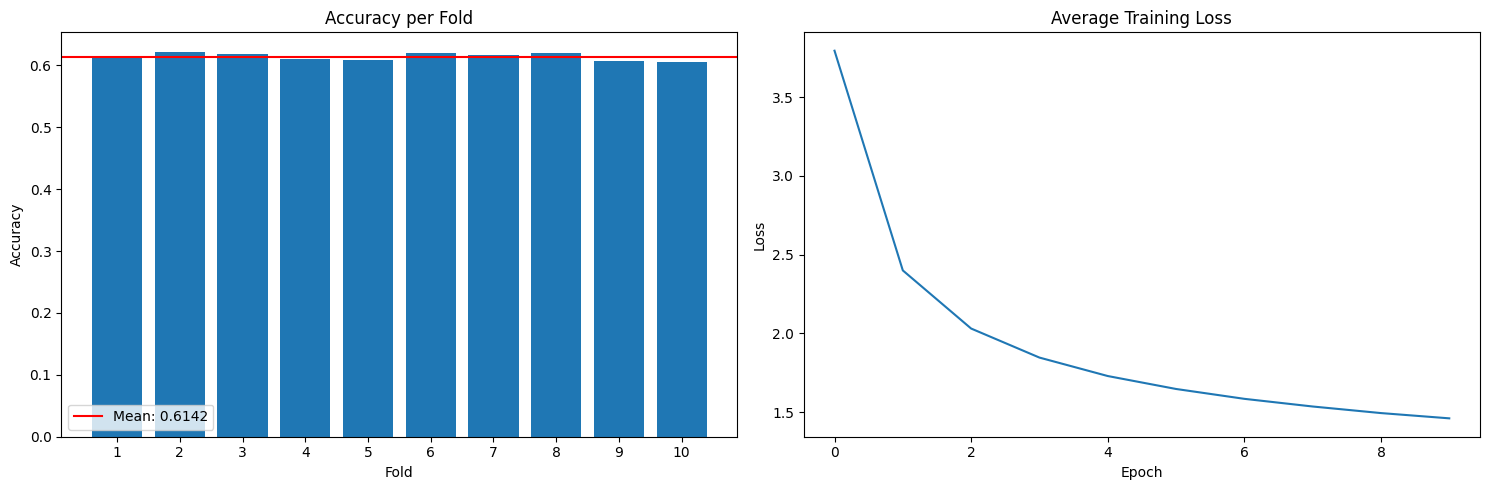


Running experiment with:
Hidden Layers: [64, 32]
Activation: tanh
Optimizer: sgd
Learning Rate: 0.01
Batch Size: 1

Fold 1: Accuracy = 48.94%
Fold 2: Accuracy = 44.45%
Fold 3: Accuracy = 44.92%
Fold 4: Accuracy = 46.33%
Fold 5: Accuracy = 45.99%
Fold 6: Accuracy = 45.85%
Fold 7: Accuracy = 46.07%
Fold 8: Accuracy = 46.19%
Fold 9: Accuracy = 45.80%
Fold 10: Accuracy = 46.13%


<Figure size 1500x500 with 0 Axes>

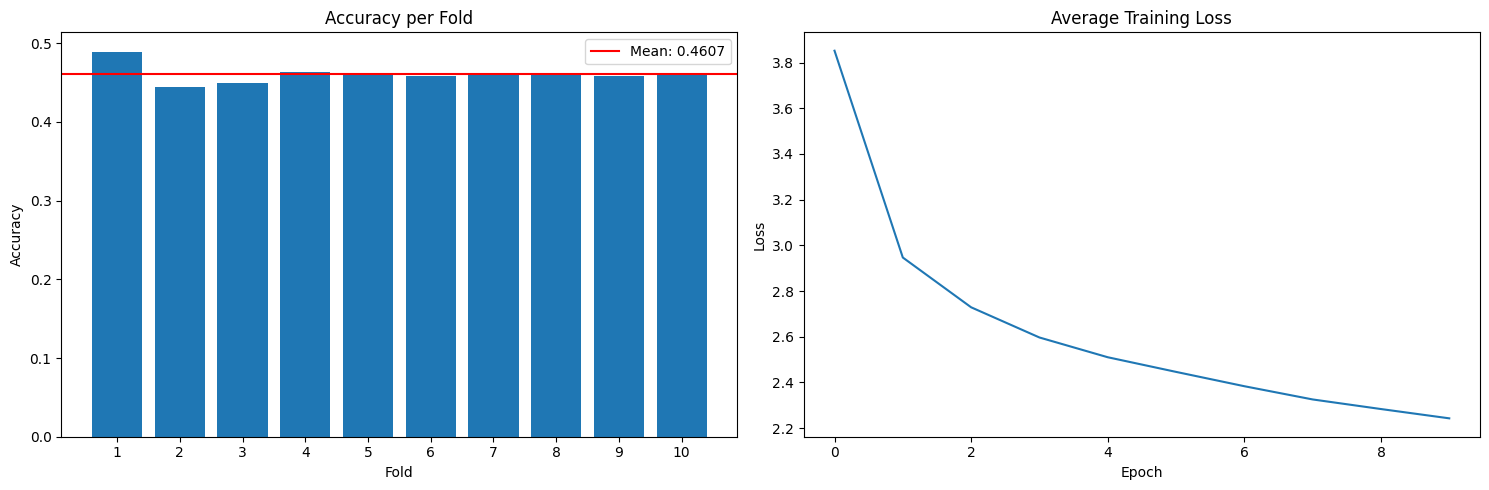


Running experiment with:
Hidden Layers: [64, 32]
Activation: relu
Optimizer: sgd
Learning Rate: 0.01
Batch Size: 1

Fold 1: Accuracy = 24.29%
Fold 2: Accuracy = 22.57%
Fold 3: Accuracy = 26.85%
Fold 4: Accuracy = 21.47%
Fold 5: Accuracy = 28.07%
Fold 6: Accuracy = 22.90%
Fold 7: Accuracy = 26.93%
Fold 8: Accuracy = 21.67%
Fold 9: Accuracy = 23.73%
Fold 10: Accuracy = 22.30%


<Figure size 1500x500 with 0 Axes>

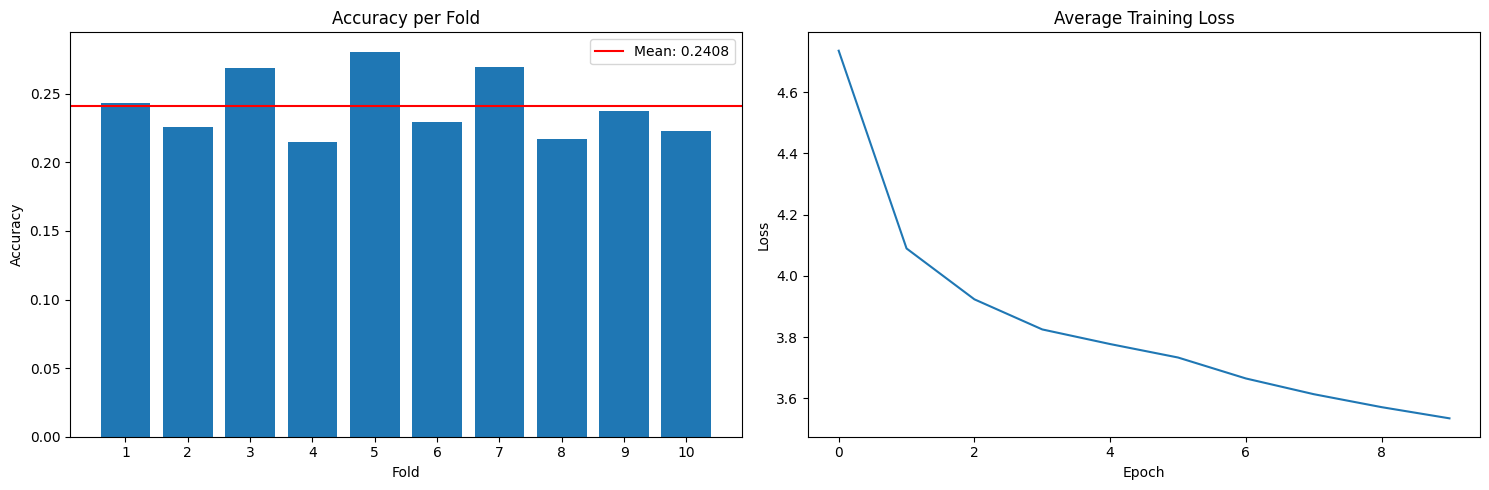


Running experiment with:
Hidden Layers: [64, 32]
Activation: sigmoid
Optimizer: batch_gradient_descent
Learning Rate: 0.01
Batch Size: Full batch

Fold 1: Accuracy = 0.54%
Fold 2: Accuracy = 0.52%
Fold 3: Accuracy = 0.10%
Fold 4: Accuracy = 0.55%
Fold 5: Accuracy = 0.55%
Fold 6: Accuracy = 0.33%
Fold 7: Accuracy = 0.13%
Fold 8: Accuracy = 0.91%
Fold 9: Accuracy = 0.33%
Fold 10: Accuracy = 0.10%


<Figure size 1500x500 with 0 Axes>

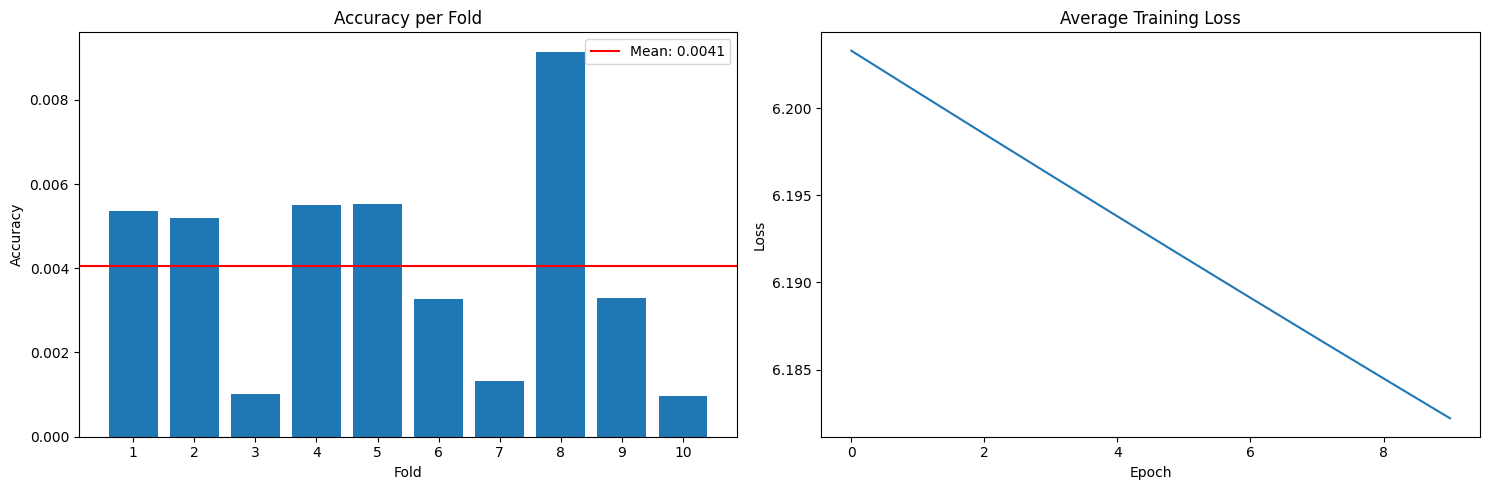


Running experiment with:
Hidden Layers: [64, 32]
Activation: tanh
Optimizer: batch_gradient_descent
Learning Rate: 0.01
Batch Size: Full batch

Fold 1: Accuracy = 0.26%
Fold 2: Accuracy = 0.16%
Fold 3: Accuracy = 0.54%
Fold 4: Accuracy = 0.23%
Fold 5: Accuracy = 0.77%
Fold 6: Accuracy = 0.40%
Fold 7: Accuracy = 0.86%
Fold 8: Accuracy = 0.26%



Running experiment with:
Hidden Layers: [64, 32]
Activation: relu
Optimizer: batch_gradient_descent
Learning Rate: 0.01
Batch Size: Full batch

Fold 1: Accuracy = 1.47%
Fold 2: Accuracy = 0.43%
Fold 3: Accuracy = 0.27%
Fold 4: Accuracy = 0.24%
Fold 5: Accuracy = 0.47%
Fold 6: Accuracy = 0.59%
Fold 7: Accuracy = 0.41%
Fold 8: Accuracy = 0.20%
Fold 9: Accuracy = 0.87%
Fold 10: Accuracy = 0.40%


<Figure size 1500x500 with 0 Axes>

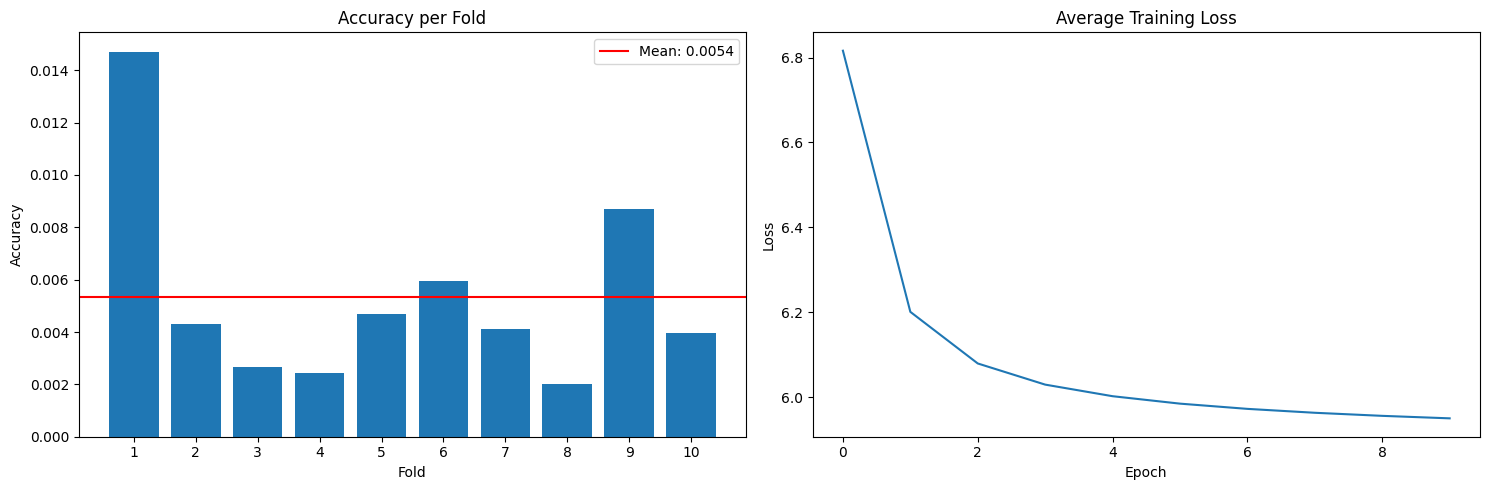


Running experiment with:
Hidden Layers: [64, 32]
Activation: sigmoid
Optimizer: mini_batch_gradient_descent
Learning Rate: 0.01
Batch Size: 32

Fold 1: Accuracy = 23.15%
Fold 2: Accuracy = 26.04%
Fold 3: Accuracy = 25.07%
Fold 4: Accuracy = 25.68%
Fold 5: Accuracy = 26.16%
Fold 6: Accuracy = 27.63%
Fold 7: Accuracy = 27.10%
Fold 8: Accuracy = 26.70%
Fold 9: Accuracy = 25.75%
Fold 10: Accuracy = 26.40%


<Figure size 1500x500 with 0 Axes>

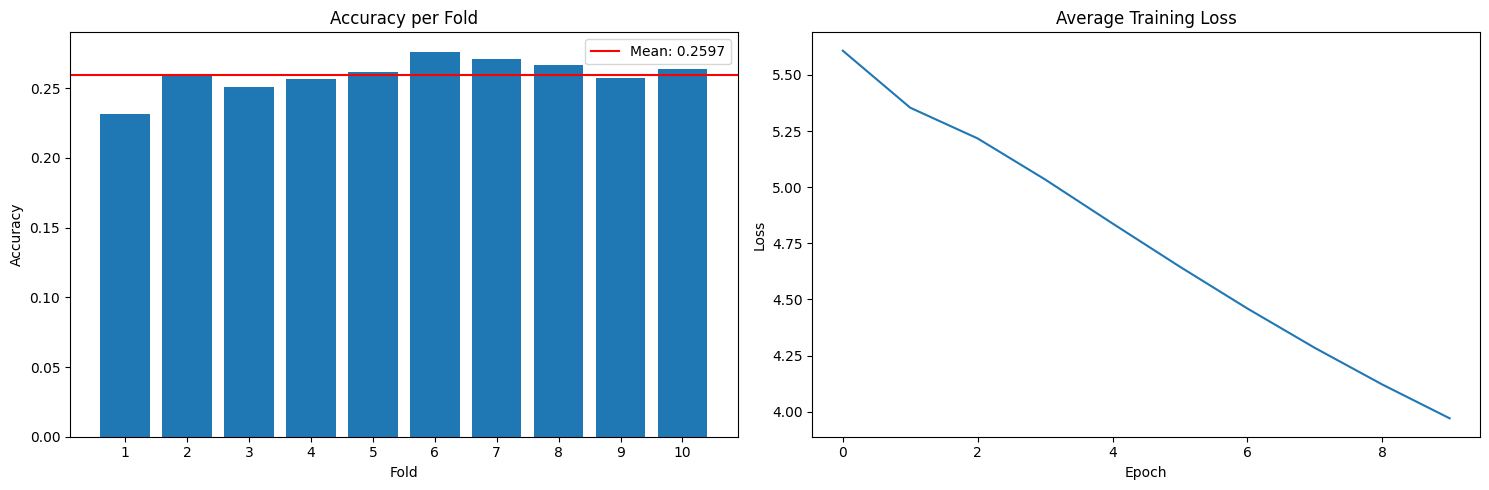


Running experiment with:
Hidden Layers: [64, 32]
Activation: tanh
Optimizer: mini_batch_gradient_descent
Learning Rate: 0.01
Batch Size: 32

Fold 1: Accuracy = 55.10%
Fold 2: Accuracy = 55.45%
Fold 3: Accuracy = 54.64%
Fold 4: Accuracy = 54.48%
Fold 5: Accuracy = 52.12%
Fold 6: Accuracy = 54.63%
Fold 7: Accuracy = 54.50%
Fold 8: Accuracy = 54.42%
Fold 9: Accuracy = 52.80%
Fold 10: Accuracy = 54.40%


<Figure size 1500x500 with 0 Axes>

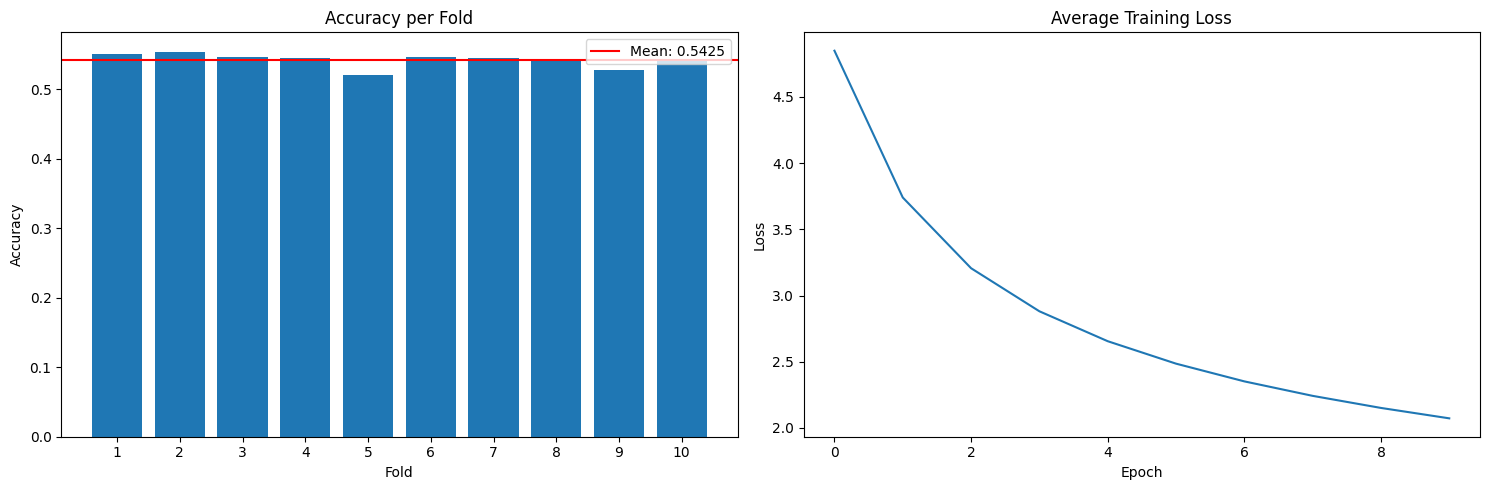


Running experiment with:
Hidden Layers: [64, 32]
Activation: relu
Optimizer: mini_batch_gradient_descent
Learning Rate: 0.01
Batch Size: 32

Fold 1: Accuracy = 59.14%
Fold 2: Accuracy = 62.21%
Fold 3: Accuracy = 59.40%
Fold 4: Accuracy = 60.39%
Fold 5: Accuracy = 51.10%
Fold 6: Accuracy = 61.45%
Fold 7: Accuracy = 61.49%
Fold 8: Accuracy = 60.76%
Fold 9: Accuracy = 60.69%
Fold 10: Accuracy = 59.26%


<Figure size 1500x500 with 0 Axes>

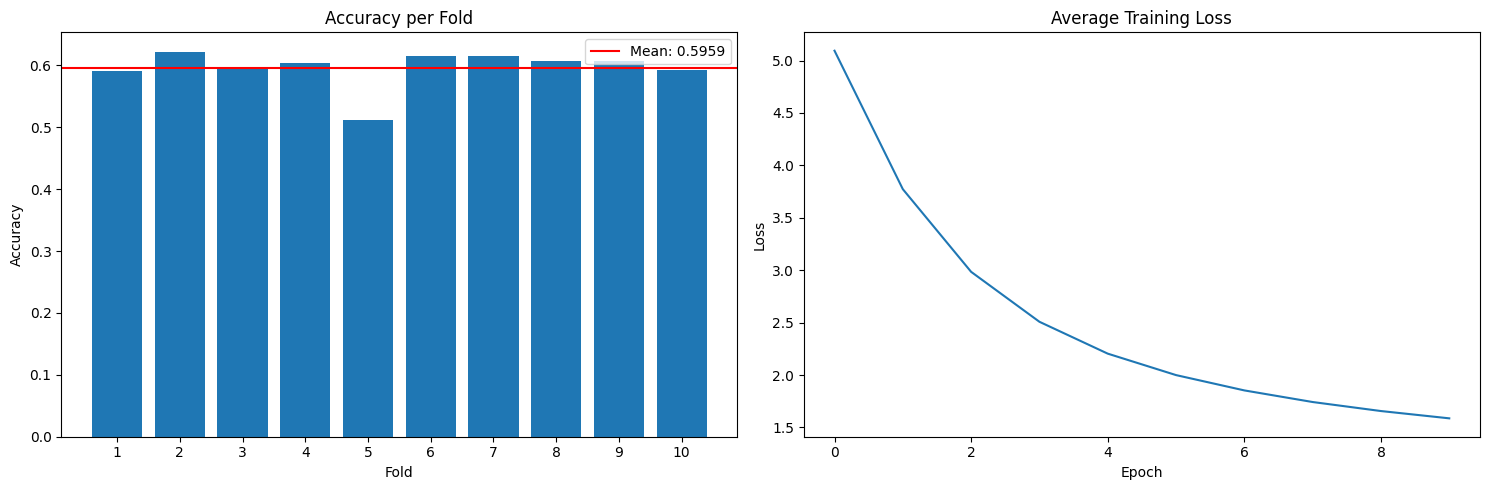



RESULTS SUMMARY (ORDERED BY MEAN ACCURACY)
Rank  Hidden Layers       ActivationOptimizer      Learning Rate  Batch Size     Mean Accuracy  Std Dev   
----------------------------------------------------------------------------------------------------
1     [64, 32]            relu      mini_batch_gradient_descent0.01           32             0.5959±0.0299
2     [64, 32]            tanh      mini_batch_gradient_descent0.01           32             0.5425±0.0096
3     [64, 32]            sigmoid   mini_batch_gradient_descent0.01           32             0.2597±0.0117
4     [64, 32]            relu      batch_gradient_descent0.01           Full batch     0.0054±0.0036


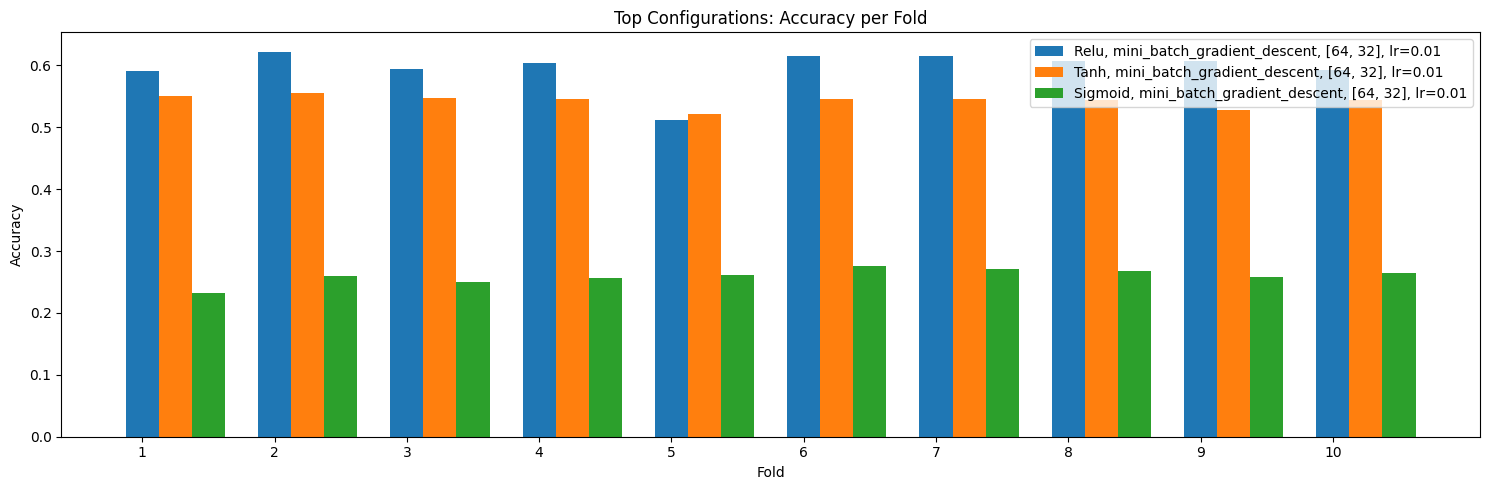


Best configuration: Relu, mini_batch_gradient_descent, layers=[64, 32], lr=0.01
Mean accuracy: 0.5959±0.0299


In [3]:
# Run hyperparameter tuning
results = run_hyperparameter_tuning()

# Plot comparison of top configurations
top_n = min(3, len(results))  # Top 3 or all if less than 3

plt.figure(figsize=(15, 5))
plt.title(f"Comparison of Top {top_n} Configurations")

for i in range(top_n):
    result = results[i]
    plt.bar(
        [x + (i*0.25) for x in range(1, 11)],  # Offset bars
        result['accuracies'],
        width=0.25,
        label=f"{result['activation'].capitalize()}, {result['optimizer']}, {result['hidden_layers']}, lr={result['learning_rate']}"
    )

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Top Configurations: Accuracy per Fold')
plt.xticks(range(1, 11))
plt.legend()
plt.tight_layout()
plt.show()

# Print best configuration results
best_config = results[0]
print(f"\nBest configuration: {best_config['activation'].capitalize()}, {best_config['optimizer']}, layers={best_config['hidden_layers']}, lr={best_config['learning_rate']}")
print(f"Mean accuracy: {best_config['mean_accuracy']:.4f}±{best_config['std_accuracy']:.4f}")

# Clean up GPU memory
torch.cuda.empty_cache()